In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import statsmodels
import statsmodels.api as sm
sns.set(style="white", color_codes=True)
sns.set_context(rc={'font.family': 'sans', 'font.size': 24, 'axes.titlesize':24, 'axes.labelsize':24})
#if you want to know current working dir
os.chdir('../..')

from src.utils import *
from src import data

%matplotlib inline

In [2]:
speeds = data.speeds_original()
sensors = data.sensors().drop_duplicates()

caching resources/dataset/originals/speeds_train.csv.gz
caching resources/dataset/preprocessed/sensors.csv.gz


# Auto correlation charts

In [3]:
speeds = speeds[[KEY, KM, DATETIME, SPEED_AVG, N_CARS]].sort_values([KEY, KM, DATETIME])

In [4]:
sensors[sensors.ROAD_TYPE == 0].head(3)

,KEY,EMERGENCY_LANE,KM,LANES,ROAD_TYPE
0,44.0,0,1410,2,0
1,146.0,0,1473,2,0
2,53.0,0,1421,2,0


In [5]:
sensors[sensors.ROAD_TYPE == 1].head(3)

,KEY,EMERGENCY_LANE,KM,LANES,ROAD_TYPE
4,17.0,1,1399,3,1
13,6.0,0,669,2,1
16,1.0,1,1557,2,1


In [6]:
sensors[sensors.ROAD_TYPE == 2].head(3)

,KEY,EMERGENCY_LANE,KM,LANES,ROAD_TYPE
89,21.0,0,616,2,2
119,36.0,0,1533,2,2
168,23.0,0,66,2,2


In [7]:
speeds = speeds[(speeds.KEY == 44) | (speeds.KEY == 146) | (speeds.KEY == 53)|
               (speeds.KEY == 17) | (speeds.KEY == 6) | (speeds.KEY == 1)|
               (speeds.KEY == 21) | (speeds.KEY == 36) | (speeds.KEY == 23)]
speeds.shape

(401272, 5)

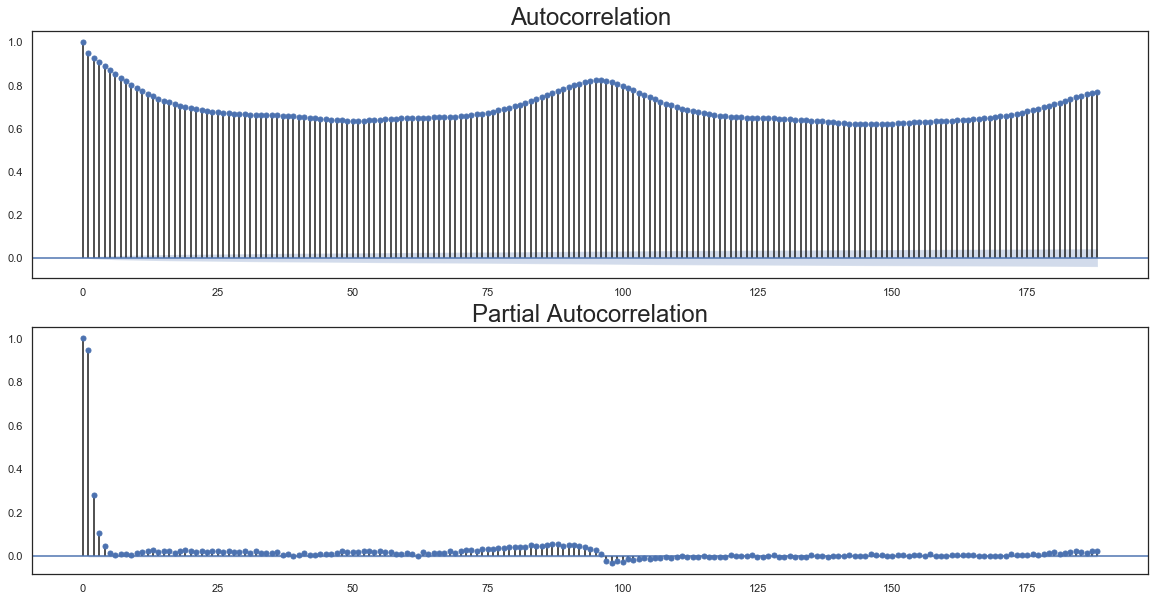

In [8]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(x=speeds[SPEED_AVG], lags=188, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(x=speeds[SPEED_AVG], lags=188, ax=ax2)

# Correlation between speeds

In [6]:
sns.set(style="ticks", color_codes=True)

In [15]:
speeds = data.speeds_original()
speeds = speeds[[KEY, KM, SPEED_AVG, SPEED_MAX, SPEED_MIN, SPEED_SD, N_CARS]]
speeds = speeds.sample(n=2000)
speeds = speeds.dropna()
sensors = data.sensors().drop_duplicates()
speeds.describe()

,KEY,KM,SPEED_AVG,SPEED_MAX,SPEED_MIN,SPEED_SD,N_VEHICLES
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,247.222500,984.949500,182.285270,236.791873,136.200813,23.133012,72.645500
std,178.702189,533.518559,31.298281,55.187695,31.820348,10.341823,124.095865
min,0.000000,17.000000,84.485341,90.608000,59.866000,0.000000,2.000000
25%,88.000000,555.500000,158.377119,194.160000,119.732000,15.679032,12.000000
50%,204.000000,989.500000,181.927920,231.374000,139.148000,22.014480,34.000000
75%,411.250000,1427.500000,205.449776,275.060000,156.946000,29.078669,80.000000
max,579.000000,1997.000000,282.341000,433.624000,276.678000,87.011702,1215.000000


In [16]:
speeds = pd.merge(speeds, sensors, on=[KEY, KM])

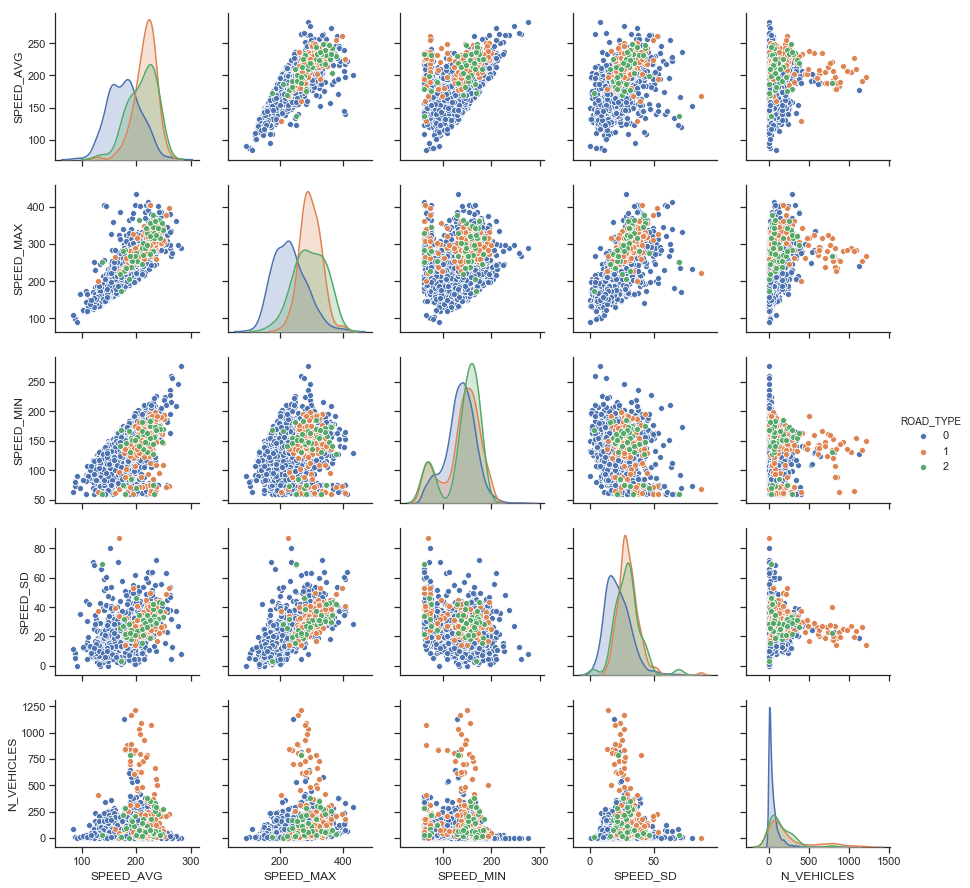

In [18]:
sns.pairplot(speeds[[SPEED_AVG, SPEED_MAX, SPEED_MIN, SPEED_SD, N_CARS, ROAD_TYPE]], hue=ROAD_TYPE,
            vars=[SPEED_AVG, SPEED_MAX, SPEED_MIN, SPEED_SD, N_CARS]);

# Seasonal decomposition

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [40]:
speeds = data.speeds_original()
sensors = data.sensors().drop_duplicates()
speeds = pd.merge(speeds, sensors, on=[KEY, KM]).dropna()
speeds = speeds[(speeds.KEY == 0) & (speeds.KM == 337)].sort_values(DATETIME)
speeds.describe()

,KEY,KM,SPEED_AVG,SPEED_SD,SPEED_MIN,SPEED_MAX,N_VEHICLES,EMERGENCY_LANE,LANES,ROAD_TYPE
count,8710.0,8710.0,8710.000000,8710.000000,8710.000000,8710.000000,8710.000000,8710.0,8710.0,8710.0
mean,0.0,337.0,216.049946,33.737127,105.728962,314.915000,158.730195,1.0,2.0,1.0
std,0.0,0.0,9.718361,6.798642,50.117610,35.178385,87.687430,0.0,0.0,0.0
min,0.0,337.0,155.328000,5.720494,59.866000,202.250000,2.000000,1.0,2.0,1.0
25%,0.0,337.0,211.194363,29.339138,59.866000,289.622000,74.000000,1.0,2.0,1.0
50%,0.0,337.0,216.897988,32.679577,72.810000,310.656000,182.000000,1.0,2.0,1.0
75%,0.0,337.0,222.077182,36.979511,160.182000,333.308000,234.000000,1.0,2.0,1.0
max,0.0,337.0,248.806645,75.932934,215.194000,414.208000,378.000000,1.0,2.0,1.0


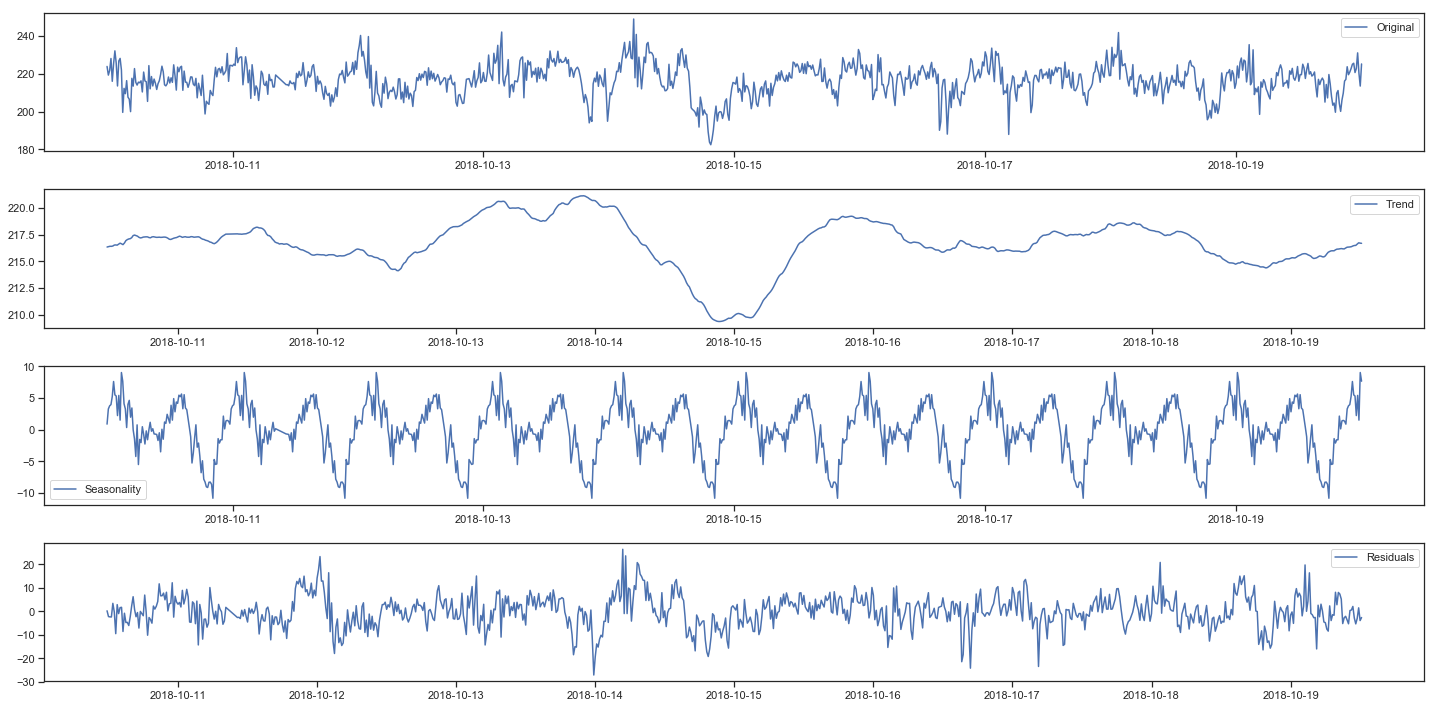

In [43]:
to_decompose = speeds[[DATETIME, SPEED_AVG]]
to_decompose = to_decompose[(to_decompose.DATETIME_UTC >= '2018-10-10') & (to_decompose.DATETIME_UTC <= '2018-10-20')].set_index(DATETIME)
decomposition = seasonal_decompose(to_decompose, freq=94)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(to_decompose, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()